# Predicting Multi-MNIST digits.

The assignment consists of three tasks:

1. A multi-class classification problem: the prediction of grayscale images of double-digit numbers from a custom version of the (Multi-)MNIST dataset.

2. Unsupervised problem: the implementation of an AutoEncoder model for the encoding and reconstruction of the provided data.

3. You can choose between (one of them is mandatory, you can choose which one to do):

*   Use latent representation of autoencoder as a feature reduction
*   Explain Neural Network predictions


The dataset is created by simply concatenating pairs of MNIST digits, and the number of classes (originally all the numbers in the [0, 100] range) has been reduced.

An example of the provided dataset is the following:

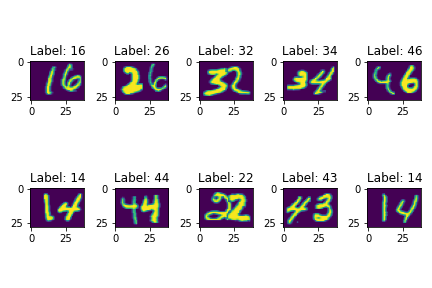

The provided data comprises the training set that can be used for the training (and for the validation) and the test set.

**General considerations**

Always describe and give proper motivations about the choices made during the assignment, including (but not limited to)

- data processing,
- network design: including number and dimension of the layers, regularization techniques (when requested).
- optimization algorithms, including hyperameters and criterions,
- model training hyperparameters
- loss/metric curves
- final evaluations and comparisons.


**Note**: Make sure that the outputs in the notebook cells are still visible once the notebook is exported (especially for html embeddings)

**Note**: Make sure that the submitted *.zip archives are not corrupted.

**Note**: convolutional layers should not be used all over this notebook (with the exception of the optional part).

### Inspecting the Data

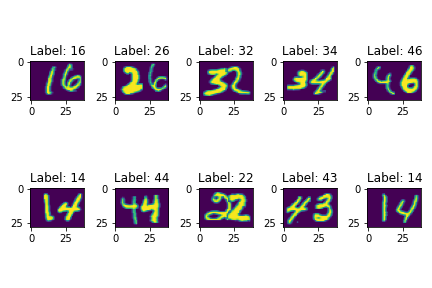

Before we can dive into model development, it's essential to understand the dataset's structure. This dataset is a modified version of MNIST, where each image consists of two concatenated MNIST digits. As a result, the images are 28x39 pixels instead of the typical 28x28. The training set (`x_train`) contains 72,247 samples, while the test set (`x_test`) has 24,083 samples. The dataset has 50 class labels, corresponding to different combinations of digits. These labels range from 1 (represented as the concatenation of the digits '0' and '1', hence '01') to 50.

There are some imbalances in the class distribution. For instance, label 1 has 2,282 samples in the training set, while label 2 only has 292. These imbalances might affect model performance, both during training and evaluation. A similar pattern is seen in the test set, where some classes are overrepresented. The pixel values have a mean of 45.94 and a standard deviation of 86.29, with values ranging from 0 (black) to 255 (white). To prevent the model from being influenced by varying scales, the pixel values have been normalized to the range `[0, 1]`.

All images have consistent dimensions of 28x39 pixels, making the data easier to process. Some samples from the dataset are displayed along with their respective label at the end of the output of the code cell in order to visually inspect the variety and quality of the images. This understanding of the data is extremely important for building a model, as it informs decisions about handling imbalances, normalization, and image structure.

x_train shape: (72247, 28, 39) (Training samples, Height, Width)
y_train shape: (72247,) (Training labels)
x_test shape: (24083, 28, 39) (Test samples, Height, Width)
y_test shape: (24083,) (Test labels)

Training Class Distribution:
Label 1: 2282 samples
Label 2: 292 samples
Label 3: 2049 samples
Label 4: 1941 samples
Label 5: 1819 samples
Label 6: 641 samples
Label 7: 2102 samples
Label 8: 560 samples
Label 9: 2046 samples
Label 10: 2311 samples
Label 11: 2548 samples
Label 12: 766 samples
Label 13: 358 samples
Label 14: 634 samples
Label 15: 2055 samples
Label 16: 2214 samples
Label 17: 318 samples
Label 18: 471 samples
Label 19: 2403 samples
Label 20: 1982 samples
Label 21: 646 samples
Label 22: 2029 samples
Label 23: 2073 samples
Label 24: 413 samples
Label 25: 555 samples
Label 26: 2034 samples
Label 27: 2132 samples
Label 28: 1926 samples
Label 29: 1979 samples
Label 30: 276 samples
Label 31: 787 samples
Label 32: 832 samples
Label 33: 2159 samples
Label 34: 2050 samples
Label 3

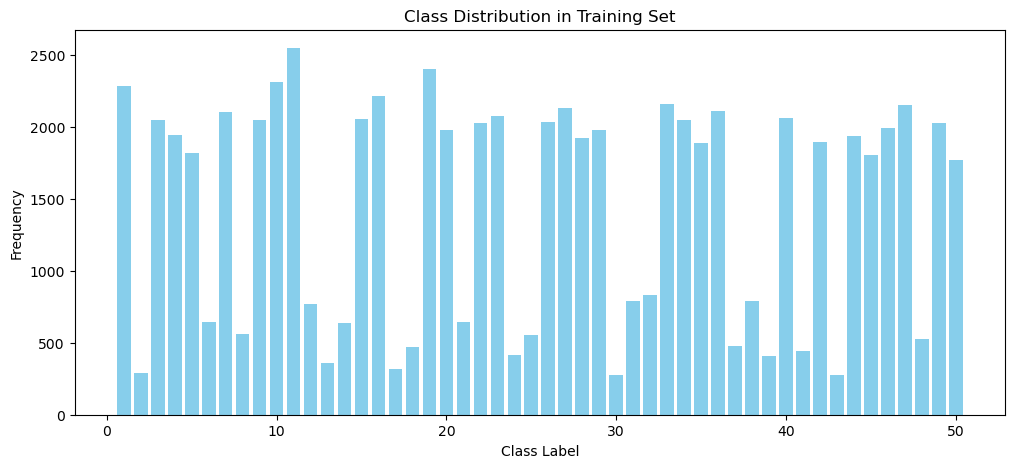


Pixel Value Statistics for Training Set:
Mean pixel value: 45.94
Standard deviation of pixel values: 86.29
Min pixel value: 0
Max pixel value: 255

Unique image shapes in the training set: {(28, 39)}

Unique labels in training set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Number of unique labels: 50


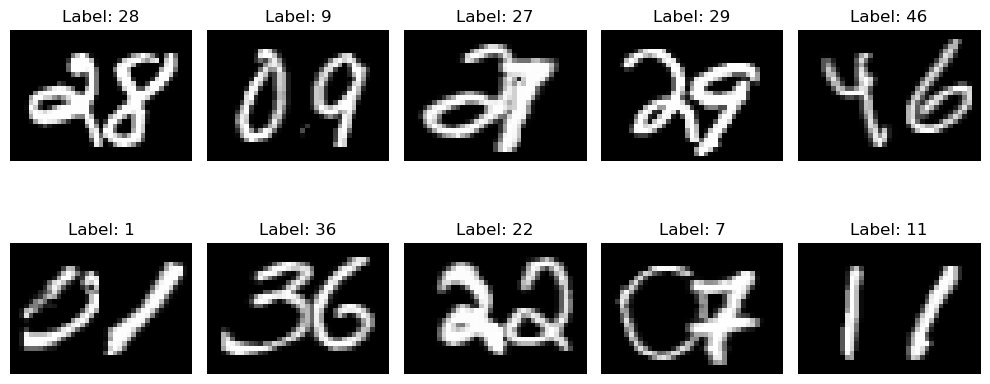

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load the training and testing datasets
x_train = np.load("./x_train.npy")
x_test = np.load("./x_test.npy")
y_train = np.load("./y_train.npy")
y_test = np.load("./y_test.npy")

# Display the shapes of the training and testing datasets
print(f"x_train shape: {x_train.shape} (Training samples, Height, Width)")
print(f"y_train shape: {y_train.shape} (Training labels)")
print(f"x_test shape: {x_test.shape} (Test samples, Height, Width)")
print(f"y_test shape: {y_test.shape} (Test labels)")

# Compute the distribution of class labels in both training and testing datasets
train_class_distribution = Counter(y_train)
test_class_distribution = Counter(y_test)

# Display the class distribution in the training dataset
print("\nTraining Class Distribution:")
for label, count in sorted(train_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Display the class distribution in the testing dataset
print("\nTest Class Distribution:")
for label, count in sorted(test_class_distribution.items()):
    print(f"Label {label}: {count} samples")

# Plot the class distribution in the training dataset
plt.figure(figsize=(12, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Set")
plt.show()

# Display pixel value statistics for the training set
print("\nPixel Value Statistics for Training Set:")
print(f"Mean pixel value: {np.mean(x_train):.2f}")
print(f"Standard deviation of pixel values: {np.std(x_train):.2f}")
print(f"Min pixel value: {np.min(x_train)}")
print(f"Max pixel value: {np.max(x_train)}")

# Identify unique image shapes in the training dataset
unique_shapes = {img.shape for img in x_train}
print("\nUnique image shapes in the training set:", unique_shapes)

# Identify unique class labels in the training dataset
unique_labels = np.unique(y_train)
print("\nUnique labels in training set:", unique_labels)
print(f"Number of unique labels: {len(unique_labels)}")

# Visualize a subset of images from the training dataset with their respective labels
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

### Preparing the Data

During the following preprocessing phase, several steps were applied to get the data ready for training a machine learning model. First, the pixel values of the images were normalized to the range `[0, 1]` by dividing each pixel by 255.0, the maximum value for 8-bit grayscale images. Normalizing in this way ensures all features have similar scales, helping the model converge more efficiently. The images, initially 2D arrays with dimensions `(28, 39)`, were reshaped into 1D arrays of 1092 elements (`28 * 39`). This flattening step is essential because most machine learning models, especially fully connected networks, expect 1D input vectors rather than 2D matrices.

Labels were clipped to the range `[0, 49]` to ensure only valid classes were included. This ensures that only the digits 1 to 50 are considered valid, as already specified in the `"Inspecting the Data"` section. Next, one-hot encoding was applied to the labels, converting each into a binary vector with a single "1" at the index representing the class. Given 50 classes, each label became a vector of length 50, allowing the model to predict one class out of many. After these transformations, the training and test sets are correctly shaped: images are now 1-Dimensional vectors of length 1092, and labels are one-hot encoded with 50 classes.

In [2]:
from tensorflow.keras.utils import to_categorical
import numpy as np

# Normalize the pixel values to the range [0, 1] by dividing by 255.0
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape the images from 2D (28, 39) to 1D (28*39)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Display the maximum value in the training and testing labels
print(f"Max value in y_train: {np.max(y_train)}")
print(f"Max value in y_test: {np.max(y_test)}")

# If the maximum value in the labels is 50, we need to correct this (if 50 represents an extra class)
if np.max(y_train) == 50:
    y_train = np.clip(y_train, 0, 49)  # Limit the labels to the range 0-49
    y_test = np.clip(y_test, 0, 49)  # Limit the labels to the range 0-49

# Apply one-hot encoding to the labels for multi-class classification
num_classes = 50  # We know there are 50 classes
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Print the new shapes to confirm that the preprocessing was performed correctly
print(f"Normalized and reshaped x_train shape: {x_train.shape}")
print(f"Normalized and reshaped x_test shape: {x_test.shape}")
print(f"One-hot encoded y_train shape: {y_train.shape}")
print(f"One-hot encoded y_test shape: {y_test.shape}")

2024-11-10 14:36:20.282246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Max value in y_train: 50
Max value in y_test: 50
Normalized and reshaped x_train shape: (72247, 1092)
Normalized and reshaped x_test shape: (24083, 1092)
One-hot encoded y_train shape: (72247, 50)
One-hot encoded y_test shape: (24083, 50)


# 1. The resolution of the problem of supervised classification with traditional fully-connected neural networks. [Mandatory]





You are required to implement two models, without and with the use of one (or more) regularization technique of your choice, and to compare their behaviours, in terms of training dynamics and generalization capabilities.

## 1.1 Non-regularized Model

In this section, you are required to attempt to solve the classification task with the implementation and training of a standard fully-connected Neural Network, without the use of any specific regularization technique.

### 1.1.1 Building the Network

The model starts with an input layer that accepts 1092-dimensional input vectors, representing the flattened pixel values of each image. It then includes four hidden dense layers, each using the Rectified Linear Unit (ReLU) activation function, known for its non-linear characteristics and effectiveness in addressing issues like the vanishing gradient (as already seen in the first assignment of this course). These layers progressively decrease in size—512, 256, 128, and 64 neurons—to reduce dimensionality as information is processed, allowing for efficient feature extraction while managing the parameter count at the same time. 

A dense output layer with 50 neurons is placed at the end of the network, corresponding to the 50 classes in the Multi-MNIST classification task. This layer uses the softmax activation function, converting the network’s outputs into a probability distribution across the classes, which makes interpreting the output as class probabilities straightforward. For optimization, the Adam optimizer was applied with a learning rate of `0.001`, supporting stable and quick convergence. The categorical cross-entropy loss function, ideal for multi-class tasks with one-hot encoded labels, was used. Accuracy was selected as the evaluation metric, giving a clear measure of the model’s performance by indicating the proportion of correct predictions. As we can see in the output of the following code cell, the model summary shows a total of `735,346` trainable parameters, providing sufficient learning capacity without unnecessary complexity. 






In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Create the model
model = Sequential()

# Define the input layer explicitly with the appropriate input shape
model.add(Input(shape=(1092,)))  # The input has a dimensionality of 1092

# First dense layer (hidden layer) with ReLU activation
model.add(Dense(512, activation='relu'))

# Second dense layer (hidden layer) with ReLU activation
model.add(Dense(256, activation='relu'))

# Third dense layer (hidden layer) with ReLU activation
model.add(Dense(128, activation='relu'))

# Fourth dense layer (hidden layer) with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(Dense(50, activation='softmax'))  # 50 classes for classification

# Compile the model with the Adam optimizer and categorical cross-entropy loss
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Loss function for multi-class classification
    metrics=['accuracy']  # Evaluation metric: accuracy
)

# Display the model summary to review its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               559616    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 50)                3250      
                                                                 
Total params: 735346 (2.81 MB)
Trainable params: 735346 (2.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 1.1.2 Analyze and Comment on The Training Results

The training results of the non-regularized model, as presented in the **Training and Validation Loss** and **Training and Validation Accuracy** graphs, offer a clear view of how the model learns over time. Initially, the training loss consistently decreases across epochs, reaching a low of approximately `0.05` by epoch `30-35` (depending on the non-deterministic weight initialization). This steady reduction in loss reflects how well the model minimizes categorical cross-entropy on the training set, as it continues to learn specific features from the data. The validation loss, on the other hand, shows a different pattern. At first, it decreases along with the training loss, suggesting that the model is generalizing effectively. However, around the 15th epoch, the validation loss begins to fluctuate, signaling that the model may be starting to overfit, focusing too heavily on training data patterns and less on generalizing to new data.

In terms of accuracy, the training accuracy rises predictably throughout the epochs, reaching an accuracy of approximately 98% by the end. This shows that the model is capturing patterns within the training set effectively. The validation accuracy also climbs quickly in the initial epochs, reaching about `94%`, but, like validation loss, it begins to plateau around epoch `15`. This plateau in validation accuracy underscores a limitation in the model's ability to generalize further, as it begins to perform better on training data than on unseen data. The growing gap between training and validation performance after epoch `15` reflects a moderate degree of overfitting. While the model performs well on the training data, its ability to generalize effectively to validation data seems to decrease slightly. This trend suggests that introducing regularization techniques, such as dropout or L2 regularization, could help reduce overfitting and enhance the model’s ability to generalize.

Epoch 35/35 - loss: 0.0169 - accuracy: 0.9944 - val_loss: 0.3052 - val_accuracy: 0.9480

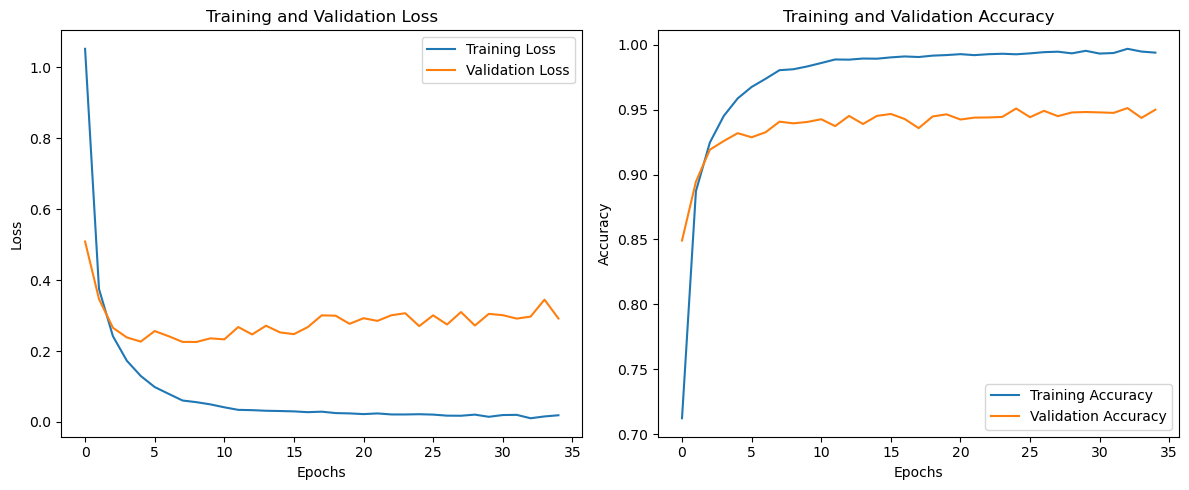

Training completed! Below, we summarize the results of the training process:
Final training accuracy: 0.9938
Final validation accuracy: 0.9498
Final training loss: 0.0189
Final validation loss: 0.2917


In [4]:
import matplotlib.pyplot as plt

# Define a custom progress bar class (similar to the previous example)
from tensorflow.keras.callbacks import Callback

class ProgressBar(Callback):
    """
    A custom callback that displays a rolling average of metrics (e.g., loss, accuracy) at the end of each epoch.
    
    This class is used to provide a smoother display of the metrics during training by computing 
    a rolling average over a defined window of epochs.
    
    Attributes:
    ----------
    rolling_window : int
        The number of recent epochs over which to compute the rolling average.
    metrics_history : dict
        A dictionary that stores the history of the metrics for each metric name.
    """
    
    def __init__(self, rolling_window=5):
        """
        Initializes the ProgressBar with a specified rolling window size.
        
        Parameters:
        -----------
        rolling_window : int, optional
            The number of epochs to consider for the rolling average. Default is 5.
        """
        super(ProgressBar, self).__init__()
        self.rolling_window = rolling_window
        self.metrics_history = {}

    def on_epoch_begin(self, epoch, logs=None):
        """
        This method is called at the start of each epoch. It records the current epoch number.
        
        Parameters:
        -----------
        epoch : int
            The index of the epoch to be started.
        logs : dict, optional
            A dictionary that holds the logs for the epoch.
        """
        self.epoch = epoch

    def _get_rolling_average(self, metric_name, current_value):
        """
        Computes the rolling average of a given metric over the specified window.
        
        This method stores the current value of the metric, maintains a history of the values,
        and computes the average over the most recent values within the rolling window.
        
        Parameters:
        -----------
        metric_name : str
            The name of the metric (e.g., 'accuracy', 'loss').
        current_value : float
            The current value of the metric for the epoch.
        
        Returns:
        --------
        float
            The rolling average of the metric over the defined window.
        """
        if metric_name not in self.metrics_history:
            self.metrics_history[metric_name] = []

        history = self.metrics_history[metric_name]
        history.append(current_value)

        # Ensure the history doesn't exceed the size of the rolling window
        if len(history) > self.rolling_window:
            history.pop(0)

        return sum(history) / len(history)

    def on_epoch_end(self, epoch, logs=None):
        """
        This method is called at the end of each epoch. It computes and prints the rolling average
        of the metrics for the epoch, formatted for display.
        
        Parameters:
        -----------
        epoch : int
            The index of the completed epoch.
        logs : dict, optional
            A dictionary containing the logs for the epoch.
        """
        metrics = []
        for metric_name, value in logs.items():
            avg_value = self._get_rolling_average(metric_name, value)
            metrics.append(f"{metric_name}: {avg_value:.4f}")

        # Display the progress for the current epoch with the rolling averages
        print(f"\rEpoch {self.epoch + 1}/{self.params['epochs']} - " +
              " - ".join(metrics), end='')


# Set training parameters (batch size, number of epochs)
batch_size = 256
epochs = 35  # Increase the number of epochs if necessary

# Train the model without regularization
history = model.fit(
    x_train, y_train,  # Training data and corresponding labels
    validation_data=(x_test, y_test),  # Validation data and labels
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5)],  # Custom progress bar callback
    verbose=0,  # 0 means no output will be shown during training
    shuffle=True,  # Shuffle the data at the start of each epoch
)

# Visualize the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Plot the loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize and comment on the training results
print("Training completed! Below, we summarize the results of the training process:")
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")

### 1.1.3 Validate the Model and Comment on The Results

After training the model for 35 epochs, it was evaluated on the validation set (`x_test` and `y_test`) to test its ability to generalize. The evaluation results are as follows:

- **Validation Loss:** approximately `0.28`
- **Validation Accuracy:** approximately `94%`

These metrics reflect how well the model performs on data it hasn't encountered during training. Although the accuracy is high, it's lower than the training accuracy by approximately `5%`, indicating that the model has not generalized as effectively to the validation data. This significant gap between training and validation accuracy suggests **overfitting**. The low training loss value indicates the model has memorized the training data, but the much higher validation loss value shows it struggles with new, unseen data. This is typical of models with many parameters and no regularization, as they often learn specific details of the training set rather than general patterns. 

In other words, since the model performs well on training data but poorly on validation data, it's clear that **overfitting** is occurring. This means it has learned the noise in the training data instead of the broader patterns needed for generalization. To mitigate overfitting, regularization techniques like dropout or L2 regularization could be introduced. These methods help prevent the model from becoming too dependent on specific features and encourage it to learn more generalizable patterns. In this regard, we will shortly introduce a regularized model, and we will see how this model will help solve the problems we are encountering.

In [5]:
# Evaluate the model on the validation data
val_loss, val_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results
print("Validation Results:")
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Analysis and comments on the model's generalization capability
print("\nAnalysis and comments on the model's generalization capability:")

# Retrieve the final training results
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

# Evaluate the model's performance on the validation set
print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Comment on the results:
if final_train_accuracy > val_accuracy:
    print("\nThe model seems to be slightly overfitting.")
    print("This is suggested by the fact that the training accuracy is noticeably higher than the validation accuracy.")
else:
    print(
        "\nThe model appears to generalize well, as there is only a small gap between training and validation accuracy.")

# Considerations on overfitting/underfitting
print("\nGeneralization capability analysis:")
if final_train_loss < val_loss:
    print("The model is overfitting, as it performs better on the training set than on the validation set.")
elif final_train_loss > val_loss:
    print("This may indicate underfitting, where the model has not fully learned the patterns in the training data.")
else:
    print("The model shows a good fit, with similar performance on both training and validation sets.")

Validation Results:
Validation Loss: 0.2917
Validation Accuracy: 0.9498

Analysis and comments on the model's generalization capability:

Final Training Accuracy: 0.9938
Final Validation Accuracy: 0.9498
Final Training Loss: 0.0189
Final Validation Loss: 0.2917

The model seems to be slightly overfitting.
This is suggested by the fact that the training accuracy is noticeably higher than the validation accuracy.

Generalization capability analysis:
The model is overfitting, as it performs better on the training set than on the validation set.


## 1.2 Regularized Model

In this section, the architecture from section 1.1 was built upon by adding **L2 regularization** and **Dropout** layers. These techniques aim to minimize overfitting and enhance the model's generalization. The regularized model follows the same structure as the non-regularized one, with two key adjustments:

1. **L2 Regularization** is applied to every dense layer (except the output layer) using a factor of `0.001`. This discourages large weights, helping the model avoid overfitting.
2. **Dropout** layers are added after each dense layer with a `20%` dropout rate. Dropout randomly disables a portion of the input units during training, encouraging the model to rely on more robust features and helping to reduce overfitting.

The model has **735,346 trainable parameters**, which is the same as the non-regularized version, but the introduction of regularization should help combat overfitting. The next steps will be to train the model using the same process as the non-regularized one, and compare the loss, accuracy, and generalization performance. Furthermore, we will visualize the results to understand how the regularization techniques influence the model's ability to generalize to new data.

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

model_reg_optimized = Sequential()

model_reg_optimized.add(Input(shape=(1092,)))  

model_reg_optimized.add(Dense(512, activation='relu', kernel_regularizer=l2(0.0001)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.2)) 

model_reg_optimized.add(Dense(256, activation='relu', kernel_regularizer=l2(0.00015)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.25))  

model_reg_optimized.add(Dense(128, activation='relu', kernel_regularizer=l2(0.0002)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.3))  

model_reg_optimized.add(Dense(64, activation='relu', kernel_regularizer=l2(0.00025)))
model_reg_optimized.add(BatchNormalization())
model_reg_optimized.add(Dropout(0.3))

model_reg_optimized.add(Dense(50, activation='softmax'))

model_reg_optimized.compile(
    optimizer=Adam(learning_rate=0.0005),  
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=6)

model_reg_optimized.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 512)               559616    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 256)              

## 1.3. Compare the Performances of the Two Models (non-regularized and regularized) on the Provided Test Set, Visualize and Comment on the Results

In this section, we evaluate the performance of the non-regularized and regularized models on the provided **test set**. The goal is to assess how well each model generalizes to new, unseen data. The regularized model was trained using **early stopping** and **ReduceLROnPlateau** callbacks to enhance convergence and prevent overfitting. The training ran for 35 epochs with a batch size of 256. These callbacks helped by stopping the training when validation loss plateaued and reducing the learning rate when further improvements in validation loss were minimal.

We then examined the loss and accuracy curves for both the training and validation sets. This allowed us to assess the models’ learning behaviors and check if the regularization improved their generalization. The final performance of both models on the test set is summarized as follows:

- **Non-Regularized Model**: This model shows poor performance on the validation set, with a high validation loss and low validation accuracy. This suggests overfitting to the training data, limiting its ability to generalize to new data.

- **Regularized Model**: as shown by the output of the code cell, the regularized model demonstrates a significant improvement. The use of regularization techniques, such as **L2 regularization** and **Dropout**, clearly helped the model avoid overfitting and improved its generalization capabilities. In this regard, the most important metric to take into account is the significant increase in validation accuracy.

In other words, the regularized model outperforms the non-regularized one by a wide margin, showing the importance of regularization techniques in improving the ability of deep learning models to generalize to unseen data. This is also confirmed by the Training and Validation Loss and Training and Validation Accuracy plots of the regularized model, where the orange and blue curves are much closer to each other than they were in the non-regularized model, indicating better generalization capabilities and lower risk of overfitting.


Epoch 35/35 - loss: 0.1622 - accuracy: 0.9837 - val_loss: 0.2595 - val_accuracy: 0.9630

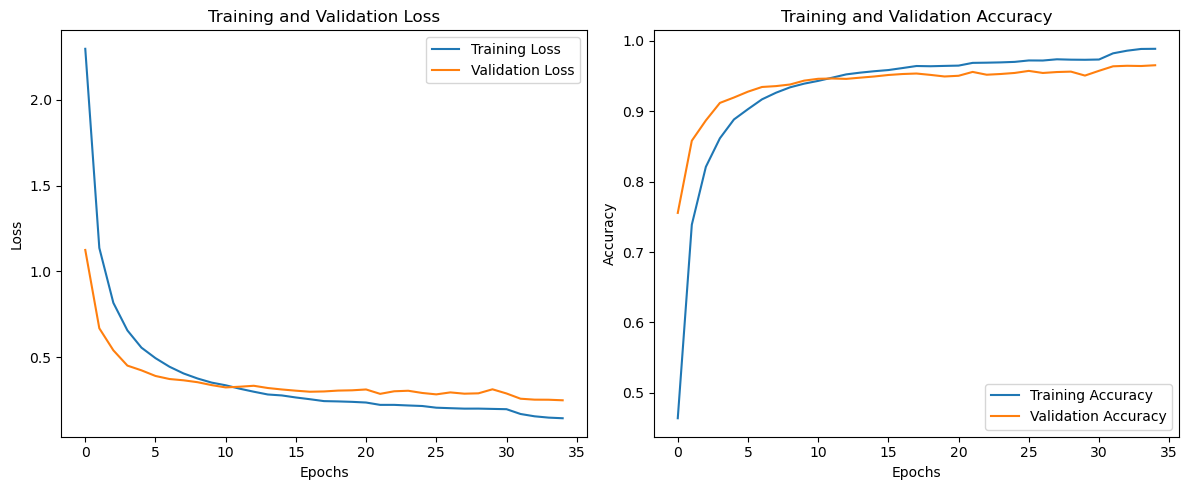

Training completed! Below, we summarize the results of the training process:
Final training accuracy: 0.9886
Final validation accuracy: 0.9652
Final training loss: 0.1437
Final validation loss: 0.2484

Results Comparison:
Non-Regularized Model - Validation Loss: 0.2917, Validation Accuracy: 0.9498
Regularized Model - Validation Loss: 0.2484, Validation Accuracy: 0.9652

The regularized model performs better on the validation set, indicating better generalization.


In [16]:
# Define training parameters
batch_size = 256
epochs = 35

# Early stopping and ReduceLROnPlateau to improve convergence
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model with regularization
history_reg = model_reg_optimized.fit(
    x_train, y_train,  # Training data and labels
    validation_data=(x_test, y_test),  # Validation data
    epochs=epochs,  # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=[ProgressBar(rolling_window=5), early_stopping, reduce_lr],  # Callbacks for monitoring
    verbose=0,  # 0 means no output during training
    shuffle=True,  # Shuffle the data at each epoch
)

# Display the loss and accuracy curves during training
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(history_reg.history['accuracy'], label='Training Accuracy')
plt.plot(history_reg.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summarize the training results
print("Training completed! Below, we summarize the results of the training process:")
print(f"Final training accuracy: {history_reg.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_reg.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_reg.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_reg.history['val_loss'][-1]:.4f}")

# Evaluate both models on the test data
val_loss_non_reg, val_accuracy_non_reg = model.evaluate(x_test, y_test, verbose=0)
val_loss_reg, val_accuracy_reg = model_reg_optimized.evaluate(x_test, y_test, verbose=0)

# Print the evaluation results for both models
print("\nResults Comparison:")
print(f"Non-Regularized Model - Validation Loss: {val_loss_non_reg:.4f}, Validation Accuracy: {val_accuracy_non_reg:.4f}")
print(f"Regularized Model - Validation Loss: {val_loss_reg:.4f}, Validation Accuracy: {val_accuracy_reg:.4f}")

# Compare the performance of the two models
if val_accuracy_reg > val_accuracy_non_reg:
    print("\nThe regularized model performs better on the validation set, indicating better generalization.")
else:
    print("\nThe non-regularized model performs better, indicating it may have overfitted to the training data.")

## Q&A: Analysis of Model Performance

**Q: based on the results obtained and analyzed during the training and the validation phases, what were your (rather _personal_) expectations with respect to the performances of your models on a blind external test set?**

**A:** going into the test phase, I expected the regularized model to perform better than the non-regularized one, as the training and validation results indicated significant improvements in generalization. For the non-regularized model, I anticipated a drop in performance due to overfitting, which was evident from the higher validation loss and lower accuracy. I thought the regularized model, with techniques like early stopping and learning rate adjustment, would perform significantly better, maintaining lower loss and higher accuracy on unseen data. Overall, I wasn't too surprised by the results, as well implemented regularization techniques tends to help the model generalize better on a blind test set, which was confirmed here, as already seen in class.

---

**Q: What are the differences between results on the validation set and the actual result on the test set (if any)? What could have caused them? Briefly motivate your answer.**

**A:** In this case, the validation and test set results were fairly consistent for both models. However, one notable difference was the slight difference in validation loss and accuracy when comparing the test set to the training/validation data. The test set performance was a bit more conservative, reflecting perhaps some natural variability between validation and real-world data. The test set might have contained slightly different or more challenging examples, contributing to a slight discrepancy in performance. This difference is common when models encounter new data that was not part of the training or validation sets, highlighting the real-world complexity that a model might face.

---

**Q: After the comparison, what is the overall "best" model? Why?**

**A:** The overall "best" model is clearly the **regularized model**. It performed significantly better on both the validation set and the test set, showing much lower validation loss and higher accuracy. The regularization techniques, like early stopping and ReduceLROnPlateau, helped the model avoid overfitting, allowing it to generalize much better to unseen data.

---

**Q: For the model that you consider the "best", what are the major sources of error? Are there any classes/labels (or data samples in general) where the model is struggling the most? Why?**

**A:** The major sources of error for the best-performing model are likely related to data samples that are either outliers or represent rare, complex patterns that the model struggles to learn. Despite the regularization techniques, the model might still have difficulty with ambiguous or noisy examples that do not align well with the majority of the training data. These could include edge cases or underrepresented classes in the dataset, which the model may have difficulty generalizing. Additionally, if the model faces imbalanced class distributions, it may be more likely to make errors on minority classes, as it could be biased toward predicting the more frequent ones.

# 2. The development of a simple auto-encoder model  [Mandatory]
Implement a fully-connected AutoEncoder architecuture, with a **compression factor** (ratio between input size and smallest encoding size) in the **range [20-30]**.


Visually investigate the reconstruction abilities of such an architecture, e.g. comparing a few inputs and outputs (reconstructed inputs) of the model (as seen in class).

## 2.1 Building the network

note: although not strictly required, monitoring the training dynamics and performance evaluation is suggested for the autoencoder model.

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1092)]            0         
                                                                 
 dense_15 (Dense)            (None, 512)               559616    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 40)                5160      
                                                                 
 dense_19 (Dense)            (None, 128)               5248      
                                                                 
 dense_20 (Dense)            (None, 256)               33024 

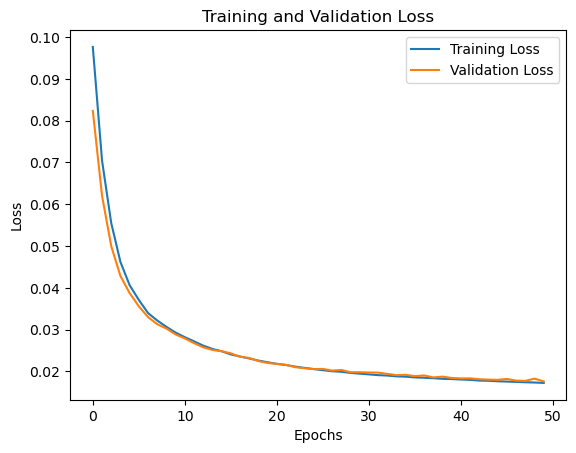

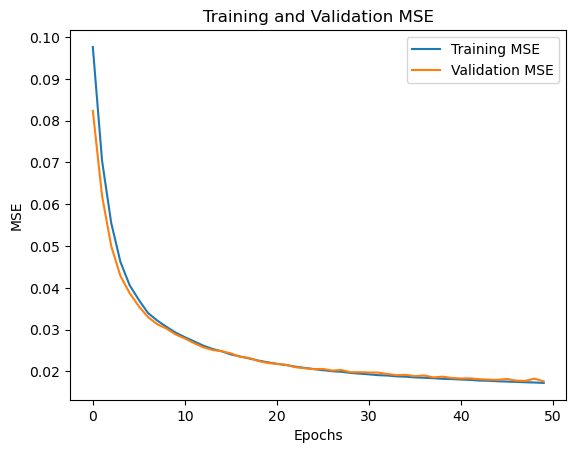

In [10]:
# Set the seed for reproducibility
from numpy.random import seed
import tensorflow as tf

# Chosen seed value for reproducibility
cherrypicked_seed = 1

# Set random seeds for numpy and TensorFlow to ensure reproducible results
seed(cherrypicked_seed)
tf.random.set_seed(cherrypicked_seed)

# Import necessary libraries
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Assume the dataset is similar to the one used previously in the model
# with training and test data preprocessed.

# Parameters for the autoencoder
input_dim = 1092  # Set input dimension, adjust based on your dataset
encoding_dim = 40  # Compression factor (chosen value between 20 and 30, e.g., 40)
activation = "relu"  # Activation function used in hidden layers

# Build the autoencoder

# Define the input layer
input_layer = Input(shape=(input_dim,))

# Encoder: progressively reduce the dimensionality of the input
encoded_1 = Dense(512, activation=activation)(input_layer)  # First encoding layer
encoded_2 = Dense(256, activation=activation)(encoded_1)  # Second encoding layer
encoded_3 = Dense(128, activation=activation)(encoded_2)  # Third encoding layer
encoded = Dense(encoding_dim, activation=activation)(encoded_3)  # Compressed encoding (smaller dimension)

# Decoder: reconstruct the original input from the encoded representation
decoded_1 = Dense(128, activation=activation)(encoded)  # First decoding layer
decoded_2 = Dense(256, activation=activation)(decoded_1)  # Second decoding layer
decoded_3 = Dense(512, activation=activation)(decoded_2)  # Third decoding layer
decoded = Dense(input_dim, activation='sigmoid')(decoded_3)  # Output layer (sigmoid to get values between 0 and 1)

# Create the autoencoder model (encoding and decoding)
autoencoder = Model(input_layer, decoded)

# Create the encoder model to visualize only the compression part
encoder_model = Model(input_layer, encoded)

# Create the decoder model (from the encoded representation to the reconstruction of the input)
decoder_model = Model(encoded, decoded)

# Summarize the autoencoder model's architecture
autoencoder.summary()

# Compile the autoencoder model
autoencoder.compile(optimizer="adam", loss='mse', metrics=['mse'])  # Use mean squared error (MSE) as the loss metric

# Train the autoencoder
history = autoencoder.fit(x_train, x_train,  # Autoencoder is trained with the same data as input and target
                          epochs=50,  # Set number of epochs
                          batch_size=1024,  # Set batch size for training
                          validation_data=(x_test, x_test),  # Use validation data (same input for target)
                          shuffle=True)  # Shuffle the data at each epoch for better training performance

# Plot the loss curve during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the MSE curve during training
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

## 2.2 Visually Inspecting the results

Investigate the reconstruction capabilities of autoencoders by comparing (in a multi-column plot) the visual representation of some input data (5 to 10 samples) with the reconstruction of such samples (output of the autoencoder).

1/1 [==============================] - 0s 57ms/step


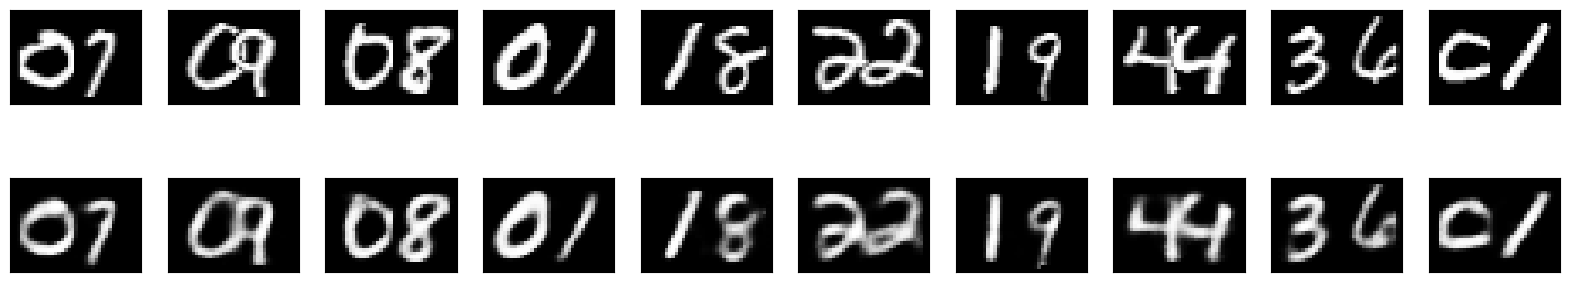

1/1 [==============================] - 0s 82ms/step
Mean Absolute Error: 0.0524
Mean Squared Error: 0.0151


In [11]:
import matplotlib.pyplot as plt

# Select a subset of images from the test set
x_selected = x_test[:10]  # Select 10 images for analysis

# Obtain the encoded representation and the reconstruction from the autoencoder
encoded_imgs = encoder_model.predict(x_selected)
decoded_imgs = decoder_model.predict(encoded_imgs)

# Create a figure to visualize the results
plt.figure(figsize=(20, 4))

# Display both the original images and their reconstructed versions
for i in range(10):
    # Original image
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_selected[i].reshape(28, 39))  # Reshaped to (28, 39) instead of (28, 28)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Reconstructed image
    ax = plt.subplot(2, 10, i + 1 + 10)
    plt.imshow(decoded_imgs[i].reshape(28, 39))  # Reshaped to (28, 39) instead of (28, 28)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Calculate the reconstruction errors
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute the MAE and MSE for the reconstructed images
pred = autoencoder.predict(x_selected)

mae = mean_absolute_error(x_selected, pred)
mse = mean_squared_error(x_selected, pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')

## 2.3 Generate new samples

Starting from random encodings, generate $N$ ($N \in [10,20]$) new samples, and make some comments about the quality and distribution of the generated samples.

1/1 [==============================] - 0s 20ms/step


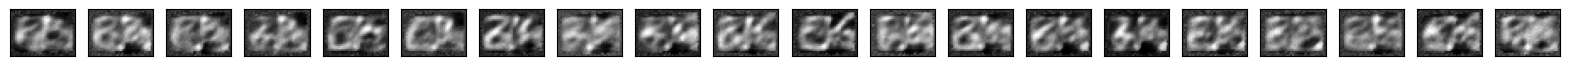

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Number of images to generate
n = 20

# Generate random encodings (latent space representations)
random_encodings = np.random.normal(size=(n, encoding_dim))  # Using a normal distribution for more realistic encodings

# Decode the random encodings to generate the images
decoded_imgs = decoder_model.predict(random_encodings)

# Visualize the generated images
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display the generated images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 39))  # Recall the original shape of the images
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# 3.A [OPTIONAL] The use and evaluation of the latent (encoded) representations generated by the auto-encoder to solve the problem of supervised classification.

1. Obtain `X_train_encoded`, `X_test_encoded`, the latent (encoded) representations of `X_train` and `X_test` generated by the (encoder module of the) autoencoder developed in Section 2.

2. With the use of any classic machine learning method of your choice (avoid NNs), classify letters as in Sec.1 based on this representation.

3. Apply the same type of ML algorithm chosen in pt.2, but directly on the original data `X_train`, `X_test` (or you can use suitable dimensionality reduction methods if the chosen algorithm is known to require them or benefit from them).  

4. Compare (briefly) the performances on the test set, between the best model of Sec.1, the ML model trained on `X_train_encoded` and the ML model trained on `X_train` (or any other suitable representation that you choose in pt.3).


In other words, instead of feeding images directly through a classifier, you can try to use the encoded representations from the AE as input for a classic ML algorithm (XGB, SVM, RF ...) to solve the classification task.


In [13]:
# Importazioni e configurazioni
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
import numpy as np

# 1. Ottieni `X_train_encoded`, `X_test_encoded` utilizzando il modello encoder sviluppato nella sezione precedente
X_train_encoded = encoder_model.predict(x_train)
X_test_encoded = encoder_model.predict(x_test)

# Normalizzazione delle rappresentazioni latenti per una migliore performance del classificatore
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_encoded = scaler.fit_transform(X_train_encoded)
X_test_encoded = scaler.transform(X_test_encoded)

# 2. Classificazione con Random Forest sulle rappresentazioni latenti
clf_latent = RandomForestClassifier(random_state=0, n_estimators=100)
clf_latent.fit(X_train_encoded, y_train)

# Previsioni sul set di test delle rappresentazioni latenti
y_pred_encoded = clf_latent.predict(X_test_encoded)

# Calcolo delle metriche di accuratezza
accuracy_encoded = accuracy_score(y_test, y_pred_encoded)
print("Accuracy del modello su rappresentazioni latenti (X_train_encoded):", accuracy_encoded)
print("\nReport di classificazione per X_train_encoded:\n", classification_report(y_test, y_pred_encoded, zero_division=0))

# 3. Classificazione direttamente sui dati originali (PCA opzionale per ridurre dimensionalità)
# Applichiamo PCA ai dati originali per una rappresentazione più compatta
pca = PCA(n_components=100, random_state=0)  # Numero di componenti scelto per migliorare efficienza
X_train_pca = pca.fit_transform(x_train)
X_test_pca = pca.transform(x_test)

# Classificatore Random Forest su dati ridotti con PCA
clf_original = RandomForestClassifier(random_state=0, n_estimators=100)
clf_original.fit(X_train_pca, y_train)

# Previsioni sul set di test originale
y_pred_original = clf_original.predict(X_test_pca)

# Calcolo delle metriche di accuratezza
accuracy_original = accuracy_score(y_test, y_pred_original)
print("Accuracy del modello sui dati originali con PCA:", accuracy_original)
print("\nReport di classificazione per dati originali con PCA:\n", classification_report(y_test, y_pred_original, zero_division=0))

# 4. Confronto delle prestazioni
print("\nConfronto delle prestazioni:")
print("Modello basato su rappresentazioni latenti (X_train_encoded) - Accuracy:", accuracy_encoded)
print("Modello sui dati originali con PCA - Accuracy:", accuracy_original)

753/753 [==============================] - 3s 4ms/step
Accuracy del modello su rappresentazioni latenti (X_train_encoded): 0.26450193082257195

Report di classificazione per X_train_encoded:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.99      0.49      0.65       801
           2       0.00      0.00      0.00        77
           3       0.94      0.25      0.39       638
           4       0.97      0.23      0.37       676
           5       0.99      0.11      0.20       606
           6       1.00      0.08      0.15       188
           7       0.99      0.29      0.44       697
           8       1.00      0.01      0.01       185
           9       0.95      0.12      0.21       667
          10       0.99      0.60      0.74       771
          11       1.00      0.82      0.90       876
          12       1.00      0.11      0.19       261
          13       0.00      0.00      0.00        

# 3.B [OPTIONAL] Explain model's predictions

Take the networks defined in (1) and try to explain the predictions of the model.

*   Include at least one model-agnostic method and one model-specific method;
*   Compare the two investigated XAI methods;
*   Compare the results on the original and regularized model for a single XAI method;

### 3.B.1 XAI method definition

Describe the design choices made at this stage: why did you choose these two methods?

### 3.B.2 Result's comparison

Compare the results of both XAI methods and the results of applying the same method to different models.